In [ ]:
#!nvidia-smi

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/bird2/code"

/content/drive/MyDrive/bird2/code


In [3]:
#ls

In [7]:
#!pip install -q pysndfx SoundFile audiomentations pretrainedmodels efficientnet_pytorch resnest

In [8]:
import numpy as np
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile
import pandas as pd
from  IPython.display import Audio
from pathlib import Path

import torch
from torch import nn, optim
from  torch.utils.data import Dataset, DataLoader

#from resnest.torch import resnest50

from matplotlib import pyplot as plt

import os, random, gc
import re, time, json
from  ast import literal_eval


from IPython.display import Audio
from sklearn.metrics import label_ranking_average_precision_score

from tqdm.notebook import tqdm
import joblib

In [104]:
import torch.nn.functional as F 

In [9]:
!pip install torchlibrosa

In [10]:
import cv2
import torchlibrosa
from torchlibrosa.augmentation import SpecAugmentation
# import torchaudio
# import torchaudio.functional as F
# import torchaudio.transforms as T

In [11]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

In [12]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-lql5_btu
  Running command git clone -q https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-lql5_btu
  Created wheel for timm: filename=timm-0.4.11-cp37-none-any.whl size=372534 sha256=d14d4dbd491e9a0326f26dac1ad3b7ec496faa0b9be14291100b1ac5b662bf9e
  Stored in directory: /tmp/pip-ephem-wheel-cache-8ku4xv36/wheels/20/b8/27/66bb141495c14daa67474754678277959ca333a352dab313a5
Successfully built timm


In [13]:
import timm
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'eca_nfnet_l0',
 'eca_nfnet_l1',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet269d',
 'ecaresnetlight',
 'efficientne

In [128]:
net = timm.create_model("rexnet_200", pretrained=True)
net.eval()
print(net)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rexnet/rexnetv1_200-8c0b7f2d.pth" to /root/.cache/torch/hub/checkpoints/rexnetv1_200-8c0b7f2d.pth


ReXNetV1(
  (stem): ConvBnAct(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (act): SiLU(inplace=True)
    )
  )
  (features): Sequential(
    (0): LinearBottleneck(
      (conv_dw): ConvBnAct(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (act): Identity()
        )
      )
      (act_dw): ReLU6()
      (conv_pwl): ConvBnAct(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (act): Identity()
        )
      )
    )
    (1): LinearBottleneck(
      (conv_exp): ConvBnAct(
        (conv): Conv2d(32, 192, kernel_size=(1, 1), st

In [ ]:
# for param in net.parameters():
#     print(param)

In [ ]:
# from efficientnet_pytorch import EfficientNet
# import pretrainedmodels
# import resnest.torch as resnest_torch

In [14]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [15]:
NUM_CLASSES = 397
SR = 32_000
DURATION = 7

MAX_READ_SAMPLES = 5 # Each record will have 10 melspecs at most, you can increase this on Colab with High Memory Enabled

# # For colab
# DATA_ROOT = Path("/content/datasets/")
# TRAIN_IMAGES_ROOT = Path("/content/datasets/audio_images")
# TRAIN_LABELS_FILE = Path("/content/datasets/rich_train_metadata.csv")
# MODEL_ROOT = Path("/content/drive/My Drive/Kaggle/BirdClef2021/models")

# DATA_ROOT = Path("../input/birdclef-2021")
# TRAIN_IMAGES_ROOT = Path("../input/kkiller-birdclef-2021/audio_images")
# TRAIN_LABELS_FILE = Path("../input/kkiller-birdclef-2021/rich_train_metadata.csv")

# MEL_PATHS = sorted(Path("../input").glob("kkiller-birdclef-mels-computer-d7-part?/rich_train_metadata.csv"))
# TRAIN_LABEL_PATHS = sorted(Path("../input").glob("kkiller-birdclef-mels-computer-d7-part?/LABEL_IDS.json"))

TRAIN_LABELS_FILE = Path("../input/melspectrogram_dataset/rich_train_metadata.csv")
TRAIN_LABEL_PATHS = Path("../input/melspectrogram_dataset/LABEL_IDS.json")
MODEL_ROOT = Path(".")

In [16]:
TRAIN_LABELS_FILE

PosixPath('../input/melspectrogram_dataset/rich_train_metadata.csv')

In [17]:
TRAIN_LABEL_PATHS

PosixPath('../input/melspectrogram_dataset/LABEL_IDS.json')

In [18]:
json_open = open(TRAIN_LABEL_PATHS, 'r')
LABEL_IDS = json.load(json_open)

In [19]:
#TRAIN_BATCH_SIZE = 100
TRAIN_BATCH_SIZE = 20
TRAIN_NUM_WORKERS = 2

#VAL_BATCH_SIZE = 128
VAL_BATCH_SIZE = 20
VAL_NUM_WORKERS = 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)

Device: cuda


In [20]:
# def get_df(mel_paths=MEL_PATHS, train_label_paths=TRAIN_LABEL_PATHS):
#   df = None
#   LABEL_IDS = {}
    
#   for file_path in mel_paths:
#     print("file_path: ", file_path)
#     temp = pd.read_csv(str(file_path), index_col=0)
#     temp["impath"] = temp.apply(lambda row: file_path.parent/"audio_images/{}/{}.npy".format(row.primary_label, row.filename), axis=1) 
    
    
#     df = temp if df is None else df.append(temp)
    
#   df["secondary_labels"] = df["secondary_labels"].apply(literal_eval)

#   for file_path in train_label_paths:
#     with open(str(file_path)) as f:
#       LABEL_IDS.update(json.load(f))

#   return LABEL_IDS, df

In [21]:
# df = pd.read_csv(TRAIN_LABELS_FILE, nrows=None)
# df["secondary_labels"] = df["secondary_labels"].apply(literal_eval)
# LABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df["primary_label"].unique()))}

# print(df.shape)
# df.head()

In [22]:
# LABEL_IDS, df = get_df()

# print(df.shape)
# df.head()

In [23]:
# df["primary_label"].value_counts()

In [24]:
# df["label_id"].min(), df["label_id"].max()

In [134]:
def get_model(name, num_classes=NUM_CLASSES):
    """
    Loads a pretrained model. 
    Supports ResNest, ResNext-wsl, EfficientNet, ResNext and ResNet.

    Arguments:
        name {str} -- Name of the model to load

    Keyword Arguments:
        num_classes {int} -- Number of classes to use (default: {1})

    Returns:
        torch model -- Pretrained model
    """
    
    model = timm.create_model(name, pretrained=True)
    
    if hasattr(model, "fc"):
        nb_ft = model.fc.in_features
        model.fc = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "_fc"):
        
        nb_ft = model._fc.in_features
        model._fc = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "classifier"):
        
        nb_ft = model.classifier.in_features
        model.classifier = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "last_linear"):
        
        nb_ft = model.last_linear.in_features
        model.last_linear = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "head"):
        if "nfnet" in name or "rexnet" in name:
            nb_ft = model.head.fc.in_features
            model.head.fc = nn.Linear(nb_ft, num_classes)
        else:
            nb_ft = model.head.in_features
            model.head = nn.Linear(nb_ft, num_classes)

    return model

In [26]:
df = pd.read_csv(TRAIN_LABELS_FILE, nrows=None)
df.head()

,Unnamed: 0,impath,label_id,filename,fold
0,0,../input/melspectrogram_dataset/acafly/XC10960...,0,XC109605_0.npy,1
1,1,../input/melspectrogram_dataset/acafly/XC10960...,0,XC109605_1.npy,3
2,2,../input/melspectrogram_dataset/acafly/XC11209...,0,XC11209_0.npy,4
3,3,../input/melspectrogram_dataset/acafly/XC11209...,0,XC11209_1.npy,0
4,4,../input/melspectrogram_dataset/acafly/XC12703...,0,XC127032_0.npy,2


In [27]:
def load_data(df):
    def load_row(row):
        # impath = TRAIN_IMAGES_ROOT/f"{row.primary_label}/{row.filename}.npy"
        #print(row.impath)
        #return row.impath, np.load(str(row.impath), allow_pickle=True)[:MAX_READ_SAMPLES]
        #print(row.impath)
        # print(np.load(str(row.impath)))
        # print(np.load(str(row.impath))[:MAX_READ_SAMPLES])
        #return row.impath, np.load(str(row.impath))[:MAX_READ_SAMPLES]
        #return row.filename, np.load(str(row.impath))[:MAX_READ_SAMPLES]
        return row.filename, np.load(str(row.impath))
        
    pool = joblib.Parallel(4)
    mapper = joblib.delayed(load_row)
    tasks = [mapper(row) for row in df.itertuples(False)]
    res = pool(tqdm(tasks))
    
    print(res)
    res = dict(res)
    return res

In [28]:
# We cache the train set to reduce training time

audio_image_store = load_data(df)
len(audio_image_store)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



108033

shape: (128, 256)


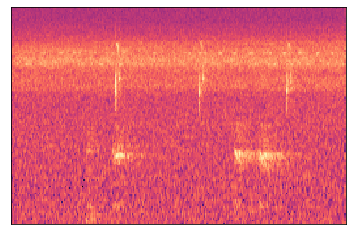

In [29]:
print("shape:", next(iter(audio_image_store.values())).shape)
lbd.specshow(next(iter(audio_image_store.values())))

In [30]:
pd.Series([len(x) for x in audio_image_store.values()])

0         128
1         128
2         128
3         128
4         128
         ... 
108028    128
108029    128
108030    128
108031    128
108032    128
Length: 108033, dtype: int64

In [31]:
# swin用
#RESIZE = [256, 562]
RESIZE = None


In [32]:
def resize(image, size=None):
    if size is not None:
        #print("image.shape", image.shape)
        
        image = cv2.resize(image, (size[0], size[1]))
        #print("resize image.shape", image.shape)

    return image

In [33]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

In [107]:
class BirdClefDataset(Dataset):

    def __init__(self, audio_image_store, meta, sr=SR, is_train=True, num_classes=NUM_CLASSES, duration=DURATION):
        
        self.audio_image_store = audio_image_store
        self.meta = meta.copy().reset_index(drop=True)
        self.sr = sr
        self.is_train = is_train
        self.num_classes = num_classes
        self.duration = duration
        self.audio_length = self.duration*self.sr
        # add------
        self.spec_augmenter = SpecAugmentation(
                                time_drop_width=32,
                                time_stripes_num=2,
                                freq_drop_width=32,
                                freq_stripes_num=4,
                              )

    @staticmethod
    def normalize(image):
        image = image.astype("float32", copy=False) / 255.0
        #image = np.stack([image, image, image])
        
        return image

    def __len__(self):
        return len(self.meta)
    
    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        melspec = self.audio_image_store[row.filename]
        stacked_img = np.stack((melspec,)*3, 0)  # チャンネル軸を追加
        image = mono_to_color(stacked_img)
        # rand = random.randint(0,1)
        # if self.is_train and rand > 0:
        #     # add------
        #     #print("image", image.shape)
        #     logmel = torch.tensor(image).unsqueeze(0)  # 次元追加
        #     #print(logmel.shape)
        #     augmented = self.spec_augmenter(logmel)
        #     image = augmented.squeeze(0).numpy()  # 次元削除
        #     #print("次元削除", image.shape)
        #     # ---------
        
        #image = image[np.random.choice(len(image))]
        image = resize(image, size=RESIZE)
        image = self.normalize(image)
        #image = torch.tensor(image).unsqueeze(0).numpy()  # 次元追加
        
        
        
        t = np.zeros(self.num_classes, dtype=np.float32) + 0.0025 # Label smoothing
        t[row.label_id] = 0.995
        #print(image.shape)
        return image, t

In [108]:
ds = BirdClefDataset(audio_image_store, meta=df, sr=SR, duration=DURATION, is_train=True)
len(ds)

108033

In [109]:
x, y = ds[np.random.choice(len(ds))]
#x, y = ds[0]
x.shape, y.shape, np.where(y >= 0.5)

((3, 128, 256), (397,), (array([210]),))

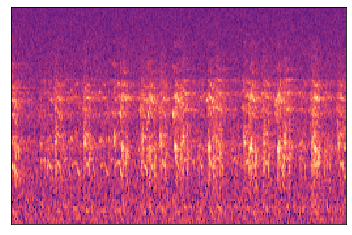

In [110]:
lbd.specshow(x[0])

In [111]:
y[:5]

array([0.0025, 0.0025, 0.0025, 0.0025, 0.0025], dtype=float32)

In [112]:
y

array([0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025,
      

In [113]:
y.shape

(397,)

# Training the model

## bi_tempered_logistic_loss

In [114]:
# https://github.com/mlpanda/bi-tempered-loss-pytorch
# https://www.kaggle.com/piantic/train-cassava-starter-using-various-loss-funcs
def log_t(u, t):
    """Compute log_t for `u'."""
    if t==1.0:
        return u.log()
    else:
        return (u.pow(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    """Compute exp_t for `u'."""
    if t==1:
        return u.exp()
    else:
        return (1.0 + (1.0-t)*u).relu().pow(1.0 / (1.0 - t))

def compute_normalization_fixed_point(activations, t, num_iters):

    """Returns the normalization value for each example (t > 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same shape as activation with the last dimension being 1.
    """
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0

    for _ in range(num_iters):
        logt_partition = torch.sum(
                exp_t(normalized_activations, t), -1, keepdim=True)
        normalized_activations = normalized_activations_step_0 * \
                logt_partition.pow(1.0-t)

    logt_partition = torch.sum(
            exp_t(normalized_activations, t), -1, keepdim=True)
    normalization_constants = - log_t(1.0 / logt_partition, t) + mu

    return normalization_constants

def compute_normalization_binary_search(activations, t, num_iters):

    """Returns the normalization value for each example (t < 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (< 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations = activations - mu

    effective_dim = \
        torch.sum(
                (normalized_activations > -1.0 / (1.0-t)).to(torch.int32),
            dim=-1, keepdim=True).to(activations.dtype)

    shape_partition = activations.shape[:-1] + (1,)
    lower = torch.zeros(shape_partition, dtype=activations.dtype, device=activations.device)
    upper = -log_t(1.0/effective_dim, t) * torch.ones_like(lower)

    for _ in range(num_iters):
        logt_partition = (upper + lower)/2.0
        sum_probs = torch.sum(
                exp_t(normalized_activations - logt_partition, t),
                dim=-1, keepdim=True)
        update = (sum_probs < 1.0).to(activations.dtype)
        lower = torch.reshape(
                lower * update + (1.0-update) * logt_partition,
                shape_partition)
        upper = torch.reshape(
                upper * (1.0 - update) + update * logt_partition,
                shape_partition)

    logt_partition = (upper + lower)/2.0
    return logt_partition + mu

class ComputeNormalization(torch.autograd.Function):
    """
    Class implementing custom backward pass for compute_normalization. See compute_normalization.
    """
    @staticmethod
    def forward(ctx, activations, t, num_iters):
        if t < 1.0:
            normalization_constants = compute_normalization_binary_search(activations, t, num_iters)
        else:
            normalization_constants = compute_normalization_fixed_point(activations, t, num_iters)

        ctx.save_for_backward(activations, normalization_constants)
        ctx.t=t
        return normalization_constants

    @staticmethod
    def backward(ctx, grad_output):
        activations, normalization_constants = ctx.saved_tensors
        t = ctx.t
        normalized_activations = activations - normalization_constants 
        probabilities = exp_t(normalized_activations, t)
        escorts = probabilities.pow(t)
        escorts = escorts / escorts.sum(dim=-1, keepdim=True)
        grad_input = escorts * grad_output
        
        return grad_input, None, None

def compute_normalization(activations, t, num_iters=5):
    """Returns the normalization value for each example. 
    Backward pass is implemented.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """
    return ComputeNormalization.apply(activations, t, num_iters)

def tempered_sigmoid(activations, t, num_iters = 5):
    """Tempered sigmoid function.
    Args:
      activations: Activations for the positive class for binary classification.
      t: Temperature tensor > 0.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_probabilities = tempered_softmax(internal_activations, t, num_iters)
    return internal_probabilities[..., 0]


def tempered_softmax(activations, t, num_iters=5):
    """Tempered softmax function.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature > 1.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    if t == 1.0:
        return activations.softmax(dim=-1)

    normalization_constants = compute_normalization(activations, t, num_iters)
    return exp_t(activations - normalization_constants, t)

def bi_tempered_binary_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing = 0.0,
        num_iters=5,
        reduction='mean'):

    """Bi-Tempered binary logistic loss.
    Args:
      activations: A tensor containing activations for class 1.
      labels: A tensor with shape as activations, containing probabilities for class 1
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing
      num_iters: Number of iterations to run the method.
    Returns:
      A loss tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_labels = torch.stack([labels.to(activations.dtype),
        1.0 - labels.to(activations.dtype)],
        dim=-1)
    return bi_tempered_logistic_loss(internal_activations, 
            internal_labels,
            t1,
            t2,
            label_smoothing = label_smoothing,
            num_iters = num_iters,
            reduction = reduction)

def bi_tempered_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing=0.0,
        num_iters=5,
        reduction = 'mean'):

    """Bi-Tempered Logistic Loss.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      labels: A tensor with shape and dtype as activations (onehot), 
        or a long tensor of one dimension less than activations (pytorch standard)
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing parameter between [0, 1). Default 0.0.
      num_iters: Number of iterations to run the method. Default 5.
      reduction: ``'none'`` | ``'mean'`` | ``'sum'``. Default ``'mean'``.
        ``'none'``: No reduction is applied, return shape is shape of
        activations without the last dimension.
        ``'mean'``: Loss is averaged over minibatch. Return shape (1,)
        ``'sum'``: Loss is summed over minibatch. Return shape (1,)
    Returns:
      A loss tensor.
    """

    if len(labels.shape)<len(activations.shape): #not one-hot
        labels_onehot = torch.zeros_like(activations)
        labels_onehot.scatter_(1, labels[..., None], 1)
    else:
        labels_onehot = labels

    if label_smoothing > 0:
        num_classes = labels_onehot.shape[-1]
        labels_onehot = ( 1 - label_smoothing * num_classes / (num_classes - 1) ) \
                * labels_onehot + \
                label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    loss_values = labels_onehot * log_t(labels_onehot + 1e-10, t1) \
            - labels_onehot * log_t(probabilities, t1) \
            - labels_onehot.pow(2.0 - t1) / (2.0 - t1) \
            + probabilities.pow(2.0 - t1) / (2.0 - t1)
    loss_values = loss_values.sum(dim = -1) #sum over classes

    if reduction == 'none':
        return loss_values
    if reduction == 'sum':
        return loss_values.sum()
    if reduction == 'mean':
        return loss_values.mean()

In [115]:
class BiTemperedLogisticLoss(nn.Module): 
    def __init__(self, t1, t2, smoothing=0.0): 
        super(BiTemperedLogisticLoss, self).__init__() 
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing
    def forward(self, logit_label, truth_label):
        loss_label = bi_tempered_logistic_loss(
            logit_label, truth_label,
            t1=self.t1, t2=self.t2,
            label_smoothing=self.smoothing,
            reduction='none'
        )
        
        loss_label = loss_label.mean()
        return loss_label

## BCEFocalLoss

In [116]:
class BCEFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(preds, targets)
        probas = torch.sigmoid(preds)
        loss = targets * self.alpha * \
            (1. - probas)**self.gamma * bce_loss + \
            (1. - targets) * probas**self.gamma * bce_loss
        loss = loss.mean()
        return loss

In [117]:
def one_step( xb, yb, net, criterion, optimizer, scheduler=None):
  xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        
  optimizer.zero_grad()
  o = net(xb)
  loss = criterion(o, yb)
  loss.backward()
  optimizer.step()
  
  with torch.no_grad():
      l = loss.item()

      o = o.sigmoid()
      yb = (yb > 0.5 )*1.0
      lrap = label_ranking_average_precision_score(yb.cpu().numpy(), o.cpu().numpy())

      o = (o > 0.5)*1.0

      prec = (o*yb).sum()/(1e-6 + o.sum())
      rec = (o*yb).sum()/(1e-6 + yb.sum())
      f1 = 2*prec*rec/(1e-6+prec+rec)

  if  scheduler is not None:
    scheduler.step()

  return l, lrap, f1.item(), rec.item(), prec.item()

In [118]:
@torch.no_grad()
def evaluate(net, criterion, val_laoder):
    net.eval()

    os, y = [], []
    val_laoder = tqdm(val_laoder, leave = False, total=len(val_laoder))

    for icount, (xb, yb) in  enumerate(val_laoder):

        y.append(yb.to(DEVICE))

        xb = xb.to(DEVICE)
        o = net(xb)

        os.append(o)

    y = torch.cat(y)
    o = torch.cat(os)

    l = criterion(o, y).item()
    
    o = o.sigmoid()
    #y = (y > 0.5)*1.0
    y = (y > 0.4)*1.0

    lrap = label_ranking_average_precision_score(y.cpu().numpy(), o.cpu().numpy())

    o = (o > 0.5)*1.0

    prec = ((o*y).sum()/(1e-6 + o.sum())).item()
    rec = ((o*y).sum()/(1e-6 + y.sum())).item()
    f1 = 2*prec*rec/(1e-6+prec+rec)

    return l, lrap, f1, rec, prec, 
    

In [119]:
def one_epoch(net, criterion, optimizer, scheduler, train_laoder, val_laoder):
  net.train()
  l, lrap, prec, rec, f1, icount = 0.,0.,0.,0., 0., 0
  train_laoder = tqdm(train_laoder, leave = False)
  epoch_bar = train_laoder
  
  for (xb, yb) in  epoch_bar:
      # epoch_bar.set_description("----|----|----|----|---->")
      _l, _lrap, _f1, _rec, _prec = one_step(xb, yb, net, criterion, optimizer)
      l += _l
      lrap += _lrap
      f1 += _f1
      rec += _rec
      prec += _prec

      icount += 1
        
      if hasattr(epoch_bar, "set_postfix") and not icount%10:
          epoch_bar.set_postfix(
            loss="{:.6f}".format(l/icount),
            lrap="{:.3f}".format(lrap/icount),
            prec="{:.3f}".format(prec/icount),
            rec="{:.3f}".format(rec/icount),
            f1="{:.3f}".format(f1/icount),
          )
  
  scheduler.step()

  l /= icount
  lrap /= icount
  f1 /= icount
  rec /= icount
  prec /= icount
  
  l_val, lrap_val, f1_val, rec_val, prec_val = evaluate(net, criterion, val_laoder)
  
  return (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val)

In [120]:
class AutoSave:
  def __init__(self, top_k=2, metric="f1", mode="min", root=None, name="ckpt"):
    self.top_k = top_k
    self.logs = []
    self.metric = metric
    self.mode = mode
    self.root = Path(root or MODEL_ROOT)
    assert self.root.exists()
    self.name = name

    self.top_models = []
    self.top_metrics = []

  def log(self, model, metrics):
    metric = metrics[self.metric]
    rank = self.rank(metric)

    self.top_metrics.insert(rank+1, metric)
    if len(self.top_metrics) > self.top_k:
      self.top_metrics.pop(0)

    self.logs.append(metrics)
    self.save(model, metric, rank, metrics["epoch"])


  def save(self, model, metric, rank, epoch):
    t = time.strftime("%Y%m%d%H%M%S")
    name = "{}_epoch_{:02d}_{}_{:.04f}_{}".format(self.name, epoch, self.metric, metric, t)
    name = re.sub(r"[^\w_-]", "", name) + ".pth"
    path = self.root.joinpath(name)

    old_model = None
    self.top_models.insert(rank+1, name)
    if len(self.top_models) > self.top_k:
      old_model = self.root.joinpath(self.top_models[0])
      self.top_models.pop(0)      
    print("save path", path)
    torch.save(model.state_dict(), path.as_posix())

    if old_model is not None:
      old_model.unlink()

    self.to_json()


  def rank(self, val):
    r = -1
    for top_val in self.top_metrics:
      if val <= top_val:
        return r
      r += 1

    return r
  
  def to_json(self):
    # t = time.strftime("%Y%m%d%H%M%S")
    name = "{}_logs".format(self.name)
    name = re.sub(r"[^\w_-]", "", name) + ".json"
    path = self.root.joinpath(name)

    with path.open("w") as f:
      json.dump(self.logs, f, indent=2)


## Mish

In [121]:
#credit : https://github.com/tyunist/memory_efficient_mish_swish/blob/master/mish.py

''' I just wanted to understand and implement custom backward activation in PyTorch so I choose this.
    You can also simply use this function below too.

class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()

    def forward(self, input):
        return input * (torch.tanh(F.softplus(input)))
'''

class Mish_func(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, i):
        result = i * torch.tanh(F.softplus(i))
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
  
        v = 1. + i.exp()
        h = v.log() 
        grad_gh = 1./h.cosh().pow_(2) 

        # Note that grad_hv * grad_vx = sigmoid(x)
        #grad_hv = 1./v  
        #grad_vx = i.exp()
        
        grad_hx = i.sigmoid()

        grad_gx = grad_gh *  grad_hx #grad_hv * grad_vx 
        
        grad_f =  torch.tanh(F.softplus(i)) + i * grad_gx 
        
        return grad_output * grad_f 


class Mish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        print("Mish initialized")
        pass
    def forward(self, input_tensor):
        return Mish_func.apply(input_tensor)

In [122]:
def replace_activations(model, existing_layer, new_layer):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = replace_activations(module, existing_layer, new_layer)

        if type(module) == existing_layer:
            layer_old = module
            layer_new = new_layer
            model._modules[name] = layer_new
    return model

In [123]:
def one_fold(model_name, fold, train_set, val_set, epochs=20, save=True, save_root=None):

  save_root = Path(save_root) or MODEL_ROOT
  print("save_root:", save_root)

  saver = AutoSave(root=save_root, name=f"birdclef_{model_name}_fold{fold}", metric="f1_val")

  net = get_model(model_name).to(DEVICE)
  if "nfnet" in model_name:
    existing_layer = torch.nn.SiLU
    new_layer = Mish()
    net = replace_activations(net, existing_layer, new_layer) # in eca_nfnet_l0 SiLU() is used, but it will be replace by Mish()

  #criterion = nn.BCEWithLogitsLoss()  # ロジット付きバイナリ交差エントロピーloss
  criterion = BCEFocalLoss()
  #criterion = BiTemperedLogisticLoss(t1=0.2, t2=1.3)

  optimizer = optim.Adam(net.parameters(), lr=8e-4)
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=epochs)

  train_data = BirdClefDataset(audio_image_store, meta=df.iloc[train_set].reset_index(drop=True),
                           sr=SR, duration=DURATION, is_train=True)
  train_laoder = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, num_workers=TRAIN_NUM_WORKERS, shuffle=True, pin_memory=True)

  val_data = BirdClefDataset(audio_image_store, meta=df.iloc[val_set].reset_index(drop=True),  sr=SR, duration=DURATION, is_train=False)
  val_laoder = DataLoader(val_data, batch_size=VAL_BATCH_SIZE, num_workers=VAL_NUM_WORKERS, shuffle=False)

  epochs_bar = tqdm(list(range(epochs)), leave=False)
  for epoch  in epochs_bar:
    epochs_bar.set_description(f"--> [EPOCH {epoch:02d}]")
    net.train()

    (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val) = one_epoch(
        net=net,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_laoder=train_laoder,
        val_laoder=val_laoder,
      )

    epochs_bar.set_postfix(
    loss="({:.6f}, {:.6f})".format(l, l_val),
    prec="({:.3f}, {:.3f})".format(prec, prec_val),
    rec="({:.3f}, {:.3f})".format(rec, rec_val),
    f1="({:.3f}, {:.3f})".format(f1, f1_val),
    lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
    )

    print(
        "[{epoch:02d}] loss: {loss} lrap: {lrap} f1: {f1} rec: {rec} prec: {prec}".format(
            epoch=epoch,
            loss="({:.6f}, {:.6f})".format(l, l_val),
            prec="({:.3f}, {:.3f})".format(prec, prec_val),
            rec="({:.3f}, {:.3f})".format(rec, rec_val),
            f1="({:.3f}, {:.3f})".format(f1, f1_val),
            lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
        )
    )

    if save:
      metrics = {
          "loss": l, "lrap": lrap, "f1": f1, "rec": rec, "prec": prec,
          "loss_val": l_val, "lrap_val": lrap_val, "f1_val": f1_val, "rec_val": rec_val, "prec_val": prec_val,
          "epoch": epoch,
      }
      
      print("save", epoch)
      saver.log(net, metrics)

In [124]:
def train(model_name, epochs=20, save=True, n_splits=5, seed=177, save_root=None, suffix="", folds=None):
  gc.collect()
  torch.cuda.empty_cache()

  save_root = save_root or MODEL_ROOT/f"{model_name}{suffix}"
  save_root.mkdir(exist_ok=True, parents=True)
  
  fold_bar = tqdm(df.reset_index().groupby("fold").index.apply(list).items(), total=df.fold.max()+1)
  
  for fold, val_set in fold_bar:
      if folds and not fold in folds:
        #print("fold continue", fold)
        continue
      
      print(f"\n############################### [FOLD {fold}]")
      fold_bar.set_description(f"[FOLD {fold}]")
      train_set = np.setdiff1d(df.index, val_set)
        
      one_fold(model_name, fold=fold, train_set=train_set , val_set=val_set , epochs=epochs, save=save, save_root=save_root)
    
      gc.collect()
      torch.cuda.empty_cache()

In [136]:
MODEL_NAMES = [
      "rexnet_150",
] 

In [137]:
# MODEL_NAMES = [
#       "swin_small_patch4_window7_224",
# ] 

In [139]:
for model_name in MODEL_NAMES:
  print("\n\n###########################################", model_name.upper())
  try:
    train(model_name, epochs=12, suffix=f"_sr{SR}_d{DURATION}_v1_v1", folds=[1])
    #train(model_name, epochs=12, suffix=f"_sr{SR}_d{DURATION}_v1_v1", folds=None)
  except Exception as e:
    # print(f"Error {model_name} : \n{e}")
    raise ValueError() from  e



########################################### REXNET_150



############################### [FOLD 1]
save_root: rexnet_150_sr32000_d7_v1_v1


[00] loss: (0.001484, 0.001017) lrap: (0.295, 0.513) f1: (0.064, 0.239) rec: (0.036, 0.139) prec: (0.366, 0.851)
save 0
save path rexnet_150_sr32000_d7_v1_v1/birdclef_rexnet_150_fold1_epoch_00_f1_val_02392_20210601154912.pth


[01] loss: (0.000960, 0.000862) lrap: (0.556, 0.611) f1: (0.264, 0.370) rec: (0.162, 0.231) prec: (0.874, 0.921)
save 1
save path rexnet_150_sr32000_d7_v1_v1/birdclef_rexnet_150_fold1_epoch_01_f1_val_03698_20210601155723.pth


[02] loss: (0.000806, 0.000800) lrap: (0.645, 0.657) f1: (0.396, 0.489) rec: (0.261, 0.338) prec: (0.918, 0.886)
save 2
save path rexnet_150_sr32000_d7_v1_v1/birdclef_rexnet_150_fold1_epoch_02_f1_val_04892_20210601160535.pth


[03] loss: (0.000685, 0.000750) lrap: (0.710, 0.686) f1: (0.498, 0.519) rec: (0.349, 0.362) prec: (0.936, 0.920)
save 3
save path rexnet_150_sr32000_d7_v1_v1/birdclef_rexnet_150_fold1_epoch_03_f1_val_05191_20210601161346.pth


[04] loss: (0.000575, 0.000735) lrap: (0.765, 0.701) f1: (0.586, 0.558) rec: (0.434, 0.403) prec: (0.951, 0.909)
save 4
save path rexnet_150_sr32000_d7_v1_v1/birdclef_rexnet_150_fold1_epoch_04_f1_val_05580_20210601162158.pth


[05] loss: (0.000466, 0.000748) lrap: (0.819, 0.715) f1: (0.669, 0.631) rec: (0.523, 0.493) prec: (0.962, 0.875)
save 5
save path rexnet_150_sr32000_d7_v1_v1/birdclef_rexnet_150_fold1_epoch_05_f1_val_06310_20210601163012.pth


[06] loss: (0.000356, 0.000795) lrap: (0.873, 0.719) f1: (0.746, 0.641) rec: (0.614, 0.504) prec: (0.973, 0.881)
save 6
save path rexnet_150_sr32000_d7_v1_v1/birdclef_rexnet_150_fold1_epoch_06_f1_val_06411_20210601163825.pth


[07] loss: (0.000254, 0.000852) lrap: (0.922, 0.720) f1: (0.817, 0.651) rec: (0.707, 0.520) prec: (0.982, 0.872)
save 7
save path rexnet_150_sr32000_d7_v1_v1/birdclef_rexnet_150_fold1_epoch_07_f1_val_06515_20210601164638.pth


[08] loss: (0.000169, 0.000938) lrap: (0.962, 0.723) f1: (0.877, 0.664) rec: (0.793, 0.541) prec: (0.989, 0.861)
save 8
save path rexnet_150_sr32000_d7_v1_v1/birdclef_rexnet_150_fold1_epoch_08_f1_val_06644_20210601165452.pth


[09] loss: (0.000108, 0.001025) lrap: (0.985, 0.723) f1: (0.921, 0.665) rec: (0.862, 0.539) prec: (0.994, 0.866)
save 9
save path rexnet_150_sr32000_d7_v1_v1/birdclef_rexnet_150_fold1_epoch_09_f1_val_06646_20210601170305.pth


[10] loss: (0.000074, 0.001099) lrap: (0.995, 0.724) f1: (0.950, 0.669) rec: (0.911, 0.546) prec: (0.997, 0.864)
save 10
save path rexnet_150_sr32000_d7_v1_v1/birdclef_rexnet_150_fold1_epoch_10_f1_val_06693_20210601171120.pth


[11] loss: (0.000057, 0.001111) lrap: (0.998, 0.724) f1: (0.966, 0.671) rec: (0.938, 0.548) prec: (0.998, 0.865)
save 11
save path rexnet_150_sr32000_d7_v1_v1/birdclef_rexnet_150_fold1_epoch_11_f1_val_06706_20210601171934.pth

